Preview of raw data:
            timestamp  plot_id  soil_moisture  ambient_temp  soil_ph  \
0 2024-01-01 00:00:00        1           23.5          15.2      6.8   
1 2024-01-01 06:00:00        1           24.1          16.5      6.7   
2 2024-01-01 12:00:00        1           22.8          14.9      6.9   
3 2024-01-01 18:00:00        2           30.2          18.0      7.0   
4 2024-01-02 00:00:00        2           29.8          17.5      7.1   

   crop_yield  
0         0.0  
1         0.0  
2         0.0  
3         1.2  
4         1.3   

Preview after feature engineering:
            timestamp  plot_id  soil_moisture  soil_moisture_roll24h
0 2024-01-01 00:00:00        1           23.5                    NaN
1 2024-01-01 06:00:00        1           24.1                    NaN
2 2024-01-01 12:00:00        1           22.8                    NaN
3 2024-01-01 18:00:00        2           30.2                    NaN
4 2024-01-02 00:00:00        2           29.8                    NaN

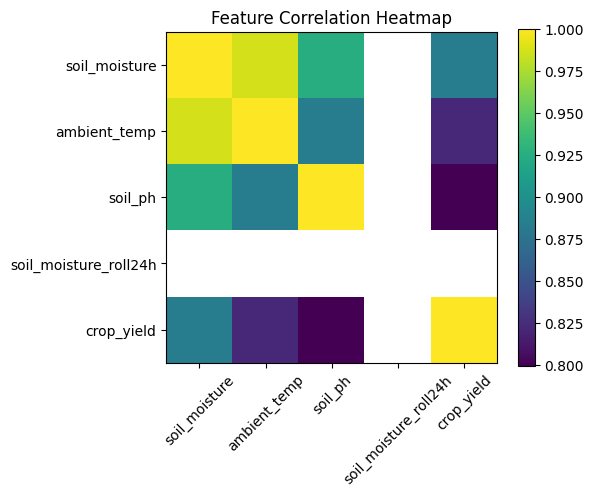

No data available after preprocessing; skipping modeling steps.


In [31]:
# Deliverable 4: Final Insights and Analysis
# Script that safely handles “no data” without exiting the kernel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    classification_report,
    silhouette_score
)
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Load Data
file_path = "C:\\Users\\DELL\\Downloads\\fieldsensor.csv"
df = pd.read_csv(file_path, parse_dates=["timestamp"])
print("Preview of raw data:")
print(df.head(), "\n")

# 2. Preprocessing
df = df[df["soil_moisture"] > 0].copy()    # drop invalid soil readings
df.ffill(inplace=True)                     # forward-fill missing values

# 3. Feature Engineering
df.sort_values(["plot_id", "timestamp"], inplace=True)
df["soil_moisture_roll24h"] = (
    df.groupby("plot_id")["soil_moisture"]
      .rolling(window=24)
      .mean()
      .reset_index(level=0, drop=True)
)

print("Preview after feature engineering:")
print(df[["timestamp","plot_id","soil_moisture","soil_moisture_roll24h"]].head(), "\n")

# 4. Exploratory Data Analysis
def plot_corr_heatmap(data):
    corr = data.corr()
    plt.figure(figsize=(6,5))
    plt.imshow(corr, cmap="viridis", interpolation="none")
    plt.colorbar()
    plt.xticks(range(len(corr)), corr.columns, rotation=45)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title("Feature Correlation Heatmap")
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(df[["soil_moisture","ambient_temp","soil_ph","soil_moisture_roll24h","crop_yield"]])

# 5. Prepare for Modeling
features = ["soil_moisture","ambient_temp","soil_ph","soil_moisture_roll24h"]
df_model = df.dropna(subset=features + ["crop_yield"]).copy()
n_samples = len(df_model)

if n_samples == 0:
    print("No data available after preprocessing; skipping modeling steps.")
else:
    X = df_model[features]
    y_reg = df_model["crop_yield"]
    y_clf = (y_reg > y_reg.median()).astype(int)

    # scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. Regression: Random Forest
    if n_samples < 2:
        print(f"I only have {n_samples} sample(s), so regression isn’t possible.")
    else:
        test_frac = 0.2 if n_samples >= 5 else 0.5
        print(f"Regression split: test_size={test_frac}, n_samples={n_samples}")
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_reg, test_size=test_frac, random_state=42
        )
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        print(f"Regression R² = {r2_score(y_test, y_pred):.2f}, MAE = {mean_absolute_error(y_test, y_pred):.2f}")
        plt.figure()
        plt.bar(features, rf.feature_importances_)
        plt.title("Feature Importances")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 7. Classification: Logistic Regression
    if n_samples < 2:
        print(f"I only have {n_samples} sample(s), so classification isn’t possible.")
    else:
        test_frac = 0.2 if n_samples >= 5 else 0.5
        print(f"Classification split: test_size={test_frac}, n_samples={n_samples}")
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
            X_scaled, y_clf, test_size=test_frac, random_state=42
        )
        clf = LogisticRegression(max_iter=200)
        clf.fit(X_train_c, y_train_c)
        y_pred_c = clf.predict(X_test_c)
        print(f"Classification accuracy = {accuracy_score(y_test_c, y_pred_c):.2f}")
        print(classification_report(y_test_c, y_pred_c))

    # 8. Clustering: K-Means
    if n_samples < 3:
        print(f"I only have {n_samples} sample(s), so clustering into 3 groups isn’t possible.")
    else:
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)
        df_model["cluster"] = clusters
        print(f"Silhouette score = {silhouette_score(X_scaled, clusters):.2f}")
        plt.figure()
        for c in np.unique(clusters):
            mask = clusters == c
            plt.scatter(
                df_model.loc[mask, "soil_moisture"],
                df_model.loc[mask, "ambient_temp"],
                label=f"Cluster {c}"
            )
        plt.xlabel("Soil Moisture")
        plt.ylabel("Ambient Temp")
        plt.title("Cluster Scatter Plot")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 9. Association Rule Mining
    dr = df_model.copy()
    dr["high_temp"]    = dr["ambient_temp"] > dr["ambient_temp"].quantile(0.75)
    dr["low_moisture"] = dr["soil_moisture"] < dr["soil_moisture"].quantile(0.25)

    basket = pd.get_dummies(dr[["high_temp","low_moisture"]])
    frequent_itemsets = apriori(basket, min_support=0.1, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

    print("Association Rules:")
    print(rules[["antecedents","consequents","support","confidence"]])
